In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)

In [2]:
import pandas as pd
from api_helpers.game_stats_helpers import load_past_n_games, matchup_past_n_games
from tensorflow.keras.utils import to_categorical

# Define columns and their variations
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST", "TOV"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

# Load and process game stats
n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns, n=10)
n_games_df = n_games_df.dropna()


X = n_games_df[columns_a+columns_b].dropna()

# Ensure indices align
y = n_games_df.loc[X.index, "WL_A"]
y.replace("L", 0, inplace=True)

y.replace("W", 1, inplace=True)
# Proceed with your code using X and y

index_1 = y[(y == 1)].index.to_list()
index_2 = y[(y == 0)].index.to_list()
y = y.loc[index_1 + index_2]
X = X.loc[index_1 + index_2]

from sklearn import preprocessing
label_enc = preprocessing.LabelEncoder()
y_encoded = label_enc.fit_transform(y)
y_encoded = pd.DataFrame(y_encoded)

2024-07-26 13:13:04.393717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 13:13:04.400117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 13:13:04.407347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 13:13:04.409287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 13:13:04.415742: I tensorflow/core/platform/cpu_feature_guar

## Create Test Train Split

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=3
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=3
)

# Build Base Blending Model

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
gbc = AdaBoostClassifier(random_state=42)
# stc = StackingClassifier(estimators=[RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier])
# Train the base models and make predictions on the validation data
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_valid)

gbc.fit(X_train, y_train)
gbc_preds = gbc.predict(X_valid)

# stc.fit(X_train, y_train)
# stc_preds = stc.predict(X_valid)


In [24]:
# Define the blending algorithm
def blend_predictions(X):
    rfc_preds = rfc.predict(X)
    gbc_preds = gbc.predict(X)
    blended_preds = np.round((rfc_preds + gbc_preds) / 2).astype(int)
    return blended_preds

In [25]:
# Make predictions on the test data using the blending algorithm
test_preds = blend_predictions(X_test)

# Calculate the accuracy score for each base model
rfc_score = accuracy_score(y_valid, rfc_preds)
gbc_score = accuracy_score(y_valid, gbc_preds)
blended_score = accuracy_score(y_test, test_preds)

print('Random Forest Classifier score: {:.4f}'.format(rfc_score))
print('Gradient Boosting Classifier score: {:.4f}'.format(gbc_score))
print('Blended Prediction: {:.4f}'.format(blended_score))

Random Forest Classifier score: 0.6052
Gradient Boosting Classifier score: 0.6175
Blended Prediction: 0.6115


In [22]:
rfc_feature_importances = rfc.feature_importances_
gbc_feature_importances = gbc.feature_importances_
print(gbc_feature_importances)

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

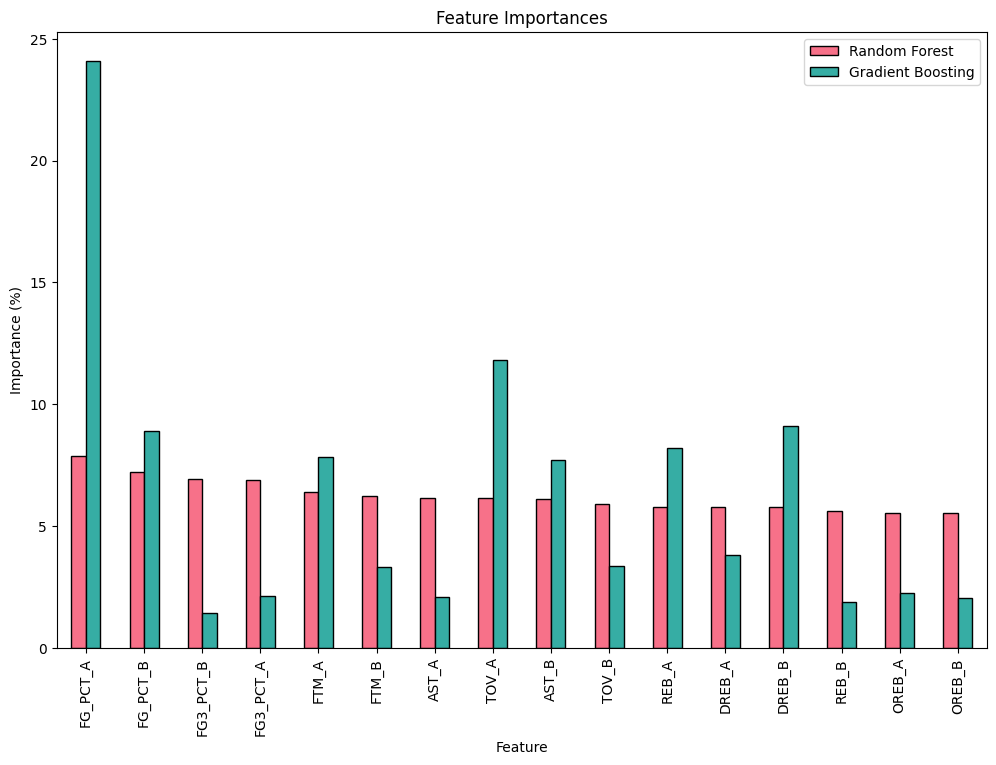

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom color palette
colors = sns.color_palette('husl', n_colors=2)

# Get the feature importances of the base models
rfc_feature_importances = rfc.feature_importances_
gbc_feature_importances = gbc.feature_importances_

# Combine the feature importances into a single DataFrame
feature_importances_df = pd.DataFrame({'feature': X_train.columns,
                                       'Random Forest': rfc_feature_importances,
                                       'Gradient Boosting': gbc_feature_importances})
# Set the 'feature' column as the index
feature_importances_df.set_index("feature", inplace=True)

# Normalize the feature importances to 100
feature_importances_df = 100 * (feature_importances_df / feature_importances_df.sum())

# Sort the feature importances by Random Forest score
feature_importances_df = feature_importances_df.sort_values('Random Forest', ascending=False)

# Plot the feature importances as a bar plot
feature_importances_df.plot(kind='bar', figsize=(12, 8), edgecolor='k', color=colors)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
plt.show()

# Build Better Model

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('knn', KNeighborsClassifier()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('svm', SVC(probability=True)))
	models.append(('bayes', GaussianNB()))
	return models

models = get_models()

In [27]:
meta_X = list()
for name, model in models:
	# fit in training set
	model.fit(X_train, y_train)
	# predict on hold out set
	yhat = model.predict(X_valid)
	# reshape predictions into a matrix with one column
	yhat = yhat.reshape(len(yhat), 1)
	# store predictions as input for blending
	meta_X.append(yhat)

In [28]:
# create 2d array from predictions, each set is an input feature
meta_X = np.hstack(meta_X)

In [29]:
# define blending model
blender = LogisticRegression()
# fit on predictions from base models
blender.fit(meta_X, y_valid)

LogisticRegression()

In [30]:
# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = np.hstack(meta_X)
	# define blending model
	blender = LogisticRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = np.hstack(meta_X)
	# predict
	return blender.predict(meta_X)

In [31]:
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Blending Accuracy: %.3f' % (score*100))

Blending Accuracy: 61.947


In [32]:
# evaluate standalone model
for name, model in models:
	# fit the model on the training dataset
	model.fit(X_train, y_train)
	# make a prediction on the test dataset
	yhat = model.predict(X_test)
	# evaluate the predictions
	score = accuracy_score(y_test, yhat)
	# report the score
	print('>%s Accuracy: %.3f' % (name, score*100))

>lr Accuracy: 61.758
>knn Accuracy: 56.000
>cart Accuracy: 53.566
